In [19]:
# import stats packages
import xarray
import cftime
import sys, os
import glob
#import fiona
import numpy as np
import pandas as pd
import ipywidgets as widgets
from netCDF4 import Dataset 
import matplotlib.pyplot as plt
from datetime import datetime as dt

# import spatial modules
import ee
import geemap
#from osgeo import gdal #install with pip3, don't use conda

# don't display warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
#********************************* Initialize GEE  ***********************************#
## trigger the authentication flow. only need once
ee.Authenticate()
## After inserting the API key initialize GEE
ee.Initialize()

Enter verification code:  4/1ARtbsJq1I2CZWNGBo8OjFgVwYjjljZ5SODqLpjWnRLwBnVL3-gFwl-2lP90



Successfully saved authorization token.


In [17]:
#****************************** define user parameters *******************************#
# setup output directory
outDIR="/home/jovyan/work/"

# setup date range in which MODIS data will be extracted
dateBEG = ee.Date("2000-01-01")
dateEND = ee.Date("2014-12-31")
# setup month in which MODIS data will be extracted 
monBEG = 1
monEND = 12

# set visualization parameters.
lst_vis_params = {
    'min': 70,
    'max': 100,
    'palette': ['21325E', '662A00', 'F6F54D']
}

In [10]:
###################load in remote sensing data for observations########################
#********************************* load in data **************************************#
# load in modis land surface albedo
modCOLL = ee.ImageCollection('MODIS/006/MOD17A2H').filter(ee.Filter.date(dateBEG, dateEND))
modCOLL = modCOLL.filter(ee.Filter.calendarRange(monBEG,monEND,'month'));
# count the number of images found
count = modCOLL.size()
print('Count: ', str(count.getInfo())+'\n')
# extract white sky and black sky albedo
modGPP = modCOLL.select('Gpp')

# load in a polygon where MODIS will be clipped out
shpDIR = "/home/jovyan/work/kougarok.shp"
shpVCT = geemap.shp_to_ee(shpDIR)

Count:  683



In [18]:
#******************************** preprocessing *************************************#
# clip out the region defined by shp file
def geeclip (image):
    return image.clip(shpVCT)
modGPP_CLP = modGPP.map(geeclip)

# 
modGPP_MN = modGPP_CLP.reduce(ee.Reducer.mean())

# make a quick display show the data region
Map = geemap.Map(center=(65.16, -164.82), zoom=13)
Map.addLayer(shpVCT, {}, 'ROI')
Map.addLayer(modGPP_MN, lst_vis_params, 'MODIS LST', True, 1)
Map.add_colorbar(vis_params=lst_vis_params, label='MODIS LST (Scale = 0.001)')
Map


Map(center=[65.16, -164.82], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [105]:
def extract_time_series(imgcoll, shp, band_name, sf):
    # Obtain image collection for all images within query dates
    # Get list of images which correspond with the above
    images = [item.get('id') for item in imgcoll.getInfo().get('features')]
    # create matrix to store the data
    store = []
    date_store = []
    # Loop over all images and extract pixel value
    for image in images:
        im = ee.Image(image)
        projection = im.projection().getInfo()['crs']
        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))
        # Extract pixel value
        data = im.reduceRegion(ee.Reducer.mean(),
                               shp,
                               500,
                               crs=projection)
        # store extract data
        store.append(data.get(band_name).getInfo())
    # Scale the returned data based on scale factor
    store = store*sf #[x * sf if isinstance(x, int) else np.nan for x in store]
    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])
    return df

modGPP_TS = extract_time_series(modGPP_CLP, shpVCT, 'Gpp', 1)

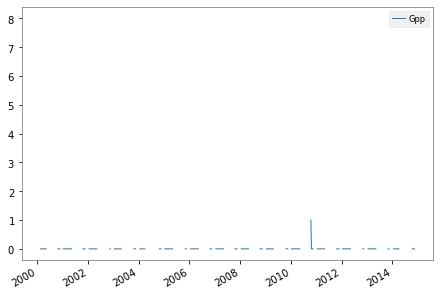

In [107]:
####### make a boxplot of mse/press result
#fig01 = plt.figure(figsize=(12, 8))
#plt.grid(color = 'white')
#plt.tick_params(labelsize = 16)
#ax = plt.axes()
#ax.set_facecolor([0.9,0.9,0.9])
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
# plot
plot01 = modGPP_TS.plot()

#plt.scatter(modGPP_TS.index, modGPP_TS.values)
#plt.xlim(0.0, 0.1)
#plt.ylim(0.0, 0.1)


In [ ]:
images = [item.get('id') for item in modGPP_CLP.getInfo().get('features')]
im = ee.Image(images[20])
projection = im.projection().getInfo()['crs']
data = im.reduceRegion(ee.Reducer.mean(),
                       shpVCT,
                       500,
                       crs=projection)


In [ ]:
modGPP_TS.index

In [51]:
# make a quick display show the data region
Map = geemap.Map(center=(65.16, -164.82), zoom=13)
Map.addLayer(shpVCT, {}, 'ROI')
Map.addLayer(im.select['Gpp'], lst_vis_params, 'MODIS LST', True, 1)
Map.add_colorbar(vis_params=lst_vis_params, label='MODIS LST (Scale = 0.001)')
Map

TypeError: 'method' object is not subscriptable

In [49]:
print(im.bandNames())

ee.List({
  "functionInvocationValue": {
    "functionName": "Image.bandNames",
    "arguments": {
      "image": {
        "functionInvocationValue": {
          "functionName": "Image.load",
          "arguments": {
            "id": {
              "constantValue": "MODIS/006/MOD17A2H/2004_01_25"
            }
          }
        }
      }
    }
  }
})


In [47]:
print(modGPP_MN)

ee.Image({
  "functionInvocationValue": {
    "functionName": "ImageCollection.reduce",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_0_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.clip",
                    "arguments": {
                      "geometry": {
                        "functionInvocationValue": {
                          "functionName": "Collection",
                          "arguments": {
                            "features": {
                              "arrayValue": {
                                "values": [
                                  {
                                    "functionInvocationValue": {
                       